<a href="https://colab.research.google.com/github/harsha-9977/AIML/blob/main/monkey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install torchvision


In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [19]:
from torchvision.datasets import ImageFolder

# Custom ImageFolder that skips hidden folders like .ipynb_checkpoints
class FilteredImageFolder(ImageFolder):
    def find_classes(self, directory):
        # Filter out folders starting with '.'
        classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and not d.startswith('.')]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

# Now use this custom class
image_datasets = {
    x: FilteredImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['training', 'validation']
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ['training', 'validation']
}

class_names = image_datasets['training'].classes
print("Monkey classes:", class_names)


Monkey classes: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


In [17]:
import os

for root, dirs, files in os.walk("/content/monkey_data"):
    level = root.replace("/content/monkey_data", "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 2 * (level + 1)
    for f in files[:3]:  # just show up to 3 files per folder
        print(f"{subindent}{f}")


monkey_data/
  10-monkey-species/
    monkey_labels.txt
    training/
      n7/
        n7135.jpg
        n7147.jpg
        n7056.jpg
      n9/
        n9062.jpg
        n9019.jpg
        n9020.jpg
      n1/
        n1132.jpg
        n1128.jpg
        n1057.jpg
      n6/
        n6113.jpg
        n6116.jpg
        n6140.jpg
      n3/
        n3148.jpg
        n3147.jpg
        n3164.jpg
      n0/
        n0021.jpg
        n0172.jpg
        n0022.jpg
      .ipynb_checkpoints/
      n4/
        n4123.jpg
        n4057.jpg
        n4056.jpg
      n8/
        n8075.jpg
        n8134.jpg
        n8143.jpg
      n2/
        n2112.jpg
        n2115.jpg
        n2148.jpg
      n5/
        n5163.jpg
        n5164.jpg
        n5045.jpg
    validation/
      n7/
        n7016.jpg
        n717.jpg
        n704.jpg
        .ipynb_checkpoints/
      n9/
        n912.jpg
        n9010.jpg
        n906.jpg
      n1/
        n116.jpg
        n120.jpg
        n103.jpg
      n6/
        n619.jpg
        

In [20]:
# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match 10 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # 10 classes for monkeys

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Model ready with final layer:", model.fc)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s]


Model ready with final layer: Linear(in_features=512, out_features=10, bias=True)


In [21]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=5):
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    return model

# Train the model
model = train_model(model, criterion, optimizer, dataloaders, device, num_epochs=5)



Epoch 1/5
--------------------
training Loss: 1.8038 Acc: 0.4540
validation Loss: 1.0104 Acc: 0.9044

Epoch 2/5
--------------------
training Loss: 0.9409 Acc: 0.8377
validation Loss: 0.5092 Acc: 0.9632

Epoch 3/5
--------------------
training Loss: 0.6399 Acc: 0.8797
validation Loss: 0.3307 Acc: 0.9743

Epoch 4/5
--------------------
training Loss: 0.5101 Acc: 0.8933
validation Loss: 0.2517 Acc: 0.9743

Epoch 5/5
--------------------
training Loss: 0.4403 Acc: 0.9015
validation Loss: 0.2091 Acc: 0.9853


In [35]:
torch.save(model.state_dict(), 'model.pth')


In [32]:
label_file_path = '/content/monkey_data/10-monkey-species/monkey_labels.txt'

id_to_name = {}

with open(label_file_path, 'r') as f:
    lines = f.readlines()[1:]  # skip header
    for line in lines:
        parts = [p.strip() for p in line.strip().split(',')]
        if len(parts) >= 3:
            class_id = parts[0]
            common_name = parts[2]
            id_to_name[class_id] = common_name

# Show the mapping
print("Species mapping:")
for k, v in id_to_name.items():
    print(f"{k}: {v}")


Species mapping:
n0: mantled_howler
n1: patas_monkey
n2: bald_uakari
n3: japanese_macaque
n4: pygmy_marmoset
n5: white_headed_capuchin
n6: silvery_marmoset
n7: common_squirrel_monkey
n8: black_headed_night_monkey
n9: nilgiri_langur


In [33]:
def predict_image(image_path, model, device, transform, class_names, id_to_name):
    model.eval()

    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(img_t)
        _, pred = torch.max(outputs, 1)
        predicted_class = class_names[pred.item()]
        species_name = id_to_name.get(predicted_class, "Unknown Species")

    # Show results
    print(f"Predicted Class ID: {predicted_class}")
    print(f"Predicted Species Name: {species_name}")

    # Display image with label
    plt.imshow(img)
    plt.title(species_name)
    plt.axis('off')
    plt.show()


Predicted Class ID: n0
Predicted Species Name: mantled_howler


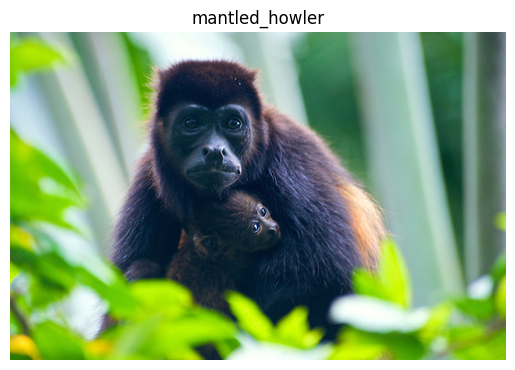

In [34]:
predict_image(
    image_path='/content/test_monkey.jpg',
    model=model,
    device=device,
    transform=data_transforms['validation'],
    class_names=class_names,
    id_to_name=id_to_name
)
